In [1]:
from pathlib import Path
import gzip
import urllib
import tempfile
from datetime import datetime
from dateutil import tz

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables

In [2]:
def xr_read_compressed_dataset(URL):
    response = urllib.request.urlopen(URL)
    compressed_file = response.read()

    with tempfile.NamedTemporaryFile(suffix='.grib2') as f:
        f.write(gzip.decompress(compressed_file))
        return xr.load_dataset(f.name)

In [3]:
# Download files

ds = xr_read_compressed_dataset('https://mrms.ncep.noaa.gov/data/2D/ReflectivityAtLowestAltitude/'
                                'MRMS_ReflectivityAtLowestAltitude.latest.grib2.gz')
ds

ECCODES ERROR   :  Truncating time: non-zero seconds(38) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(38) ignored


<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 2023-04-29T04:40:00
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 500.0
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] 2023-04-29T04:40:00
Data variables:
    unknown         (latitude, longitude) float32 -999.0 -999.0 ... -999.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2023-04-28T23:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
BOTTOM_LAT = 24
TOP_LAT = 38
LEFT_LON = -100
RIGHT_LON = -80

LAT_SLICE = slice(TOP_LAT, BOTTOM_LAT)
LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)

In [7]:
d = ds.sel(latitude=LAT_SLICE, longitude=LON_SLICE)
mrms_values = d.unknown

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/Chicago')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(d.time.values).split('.')[0])

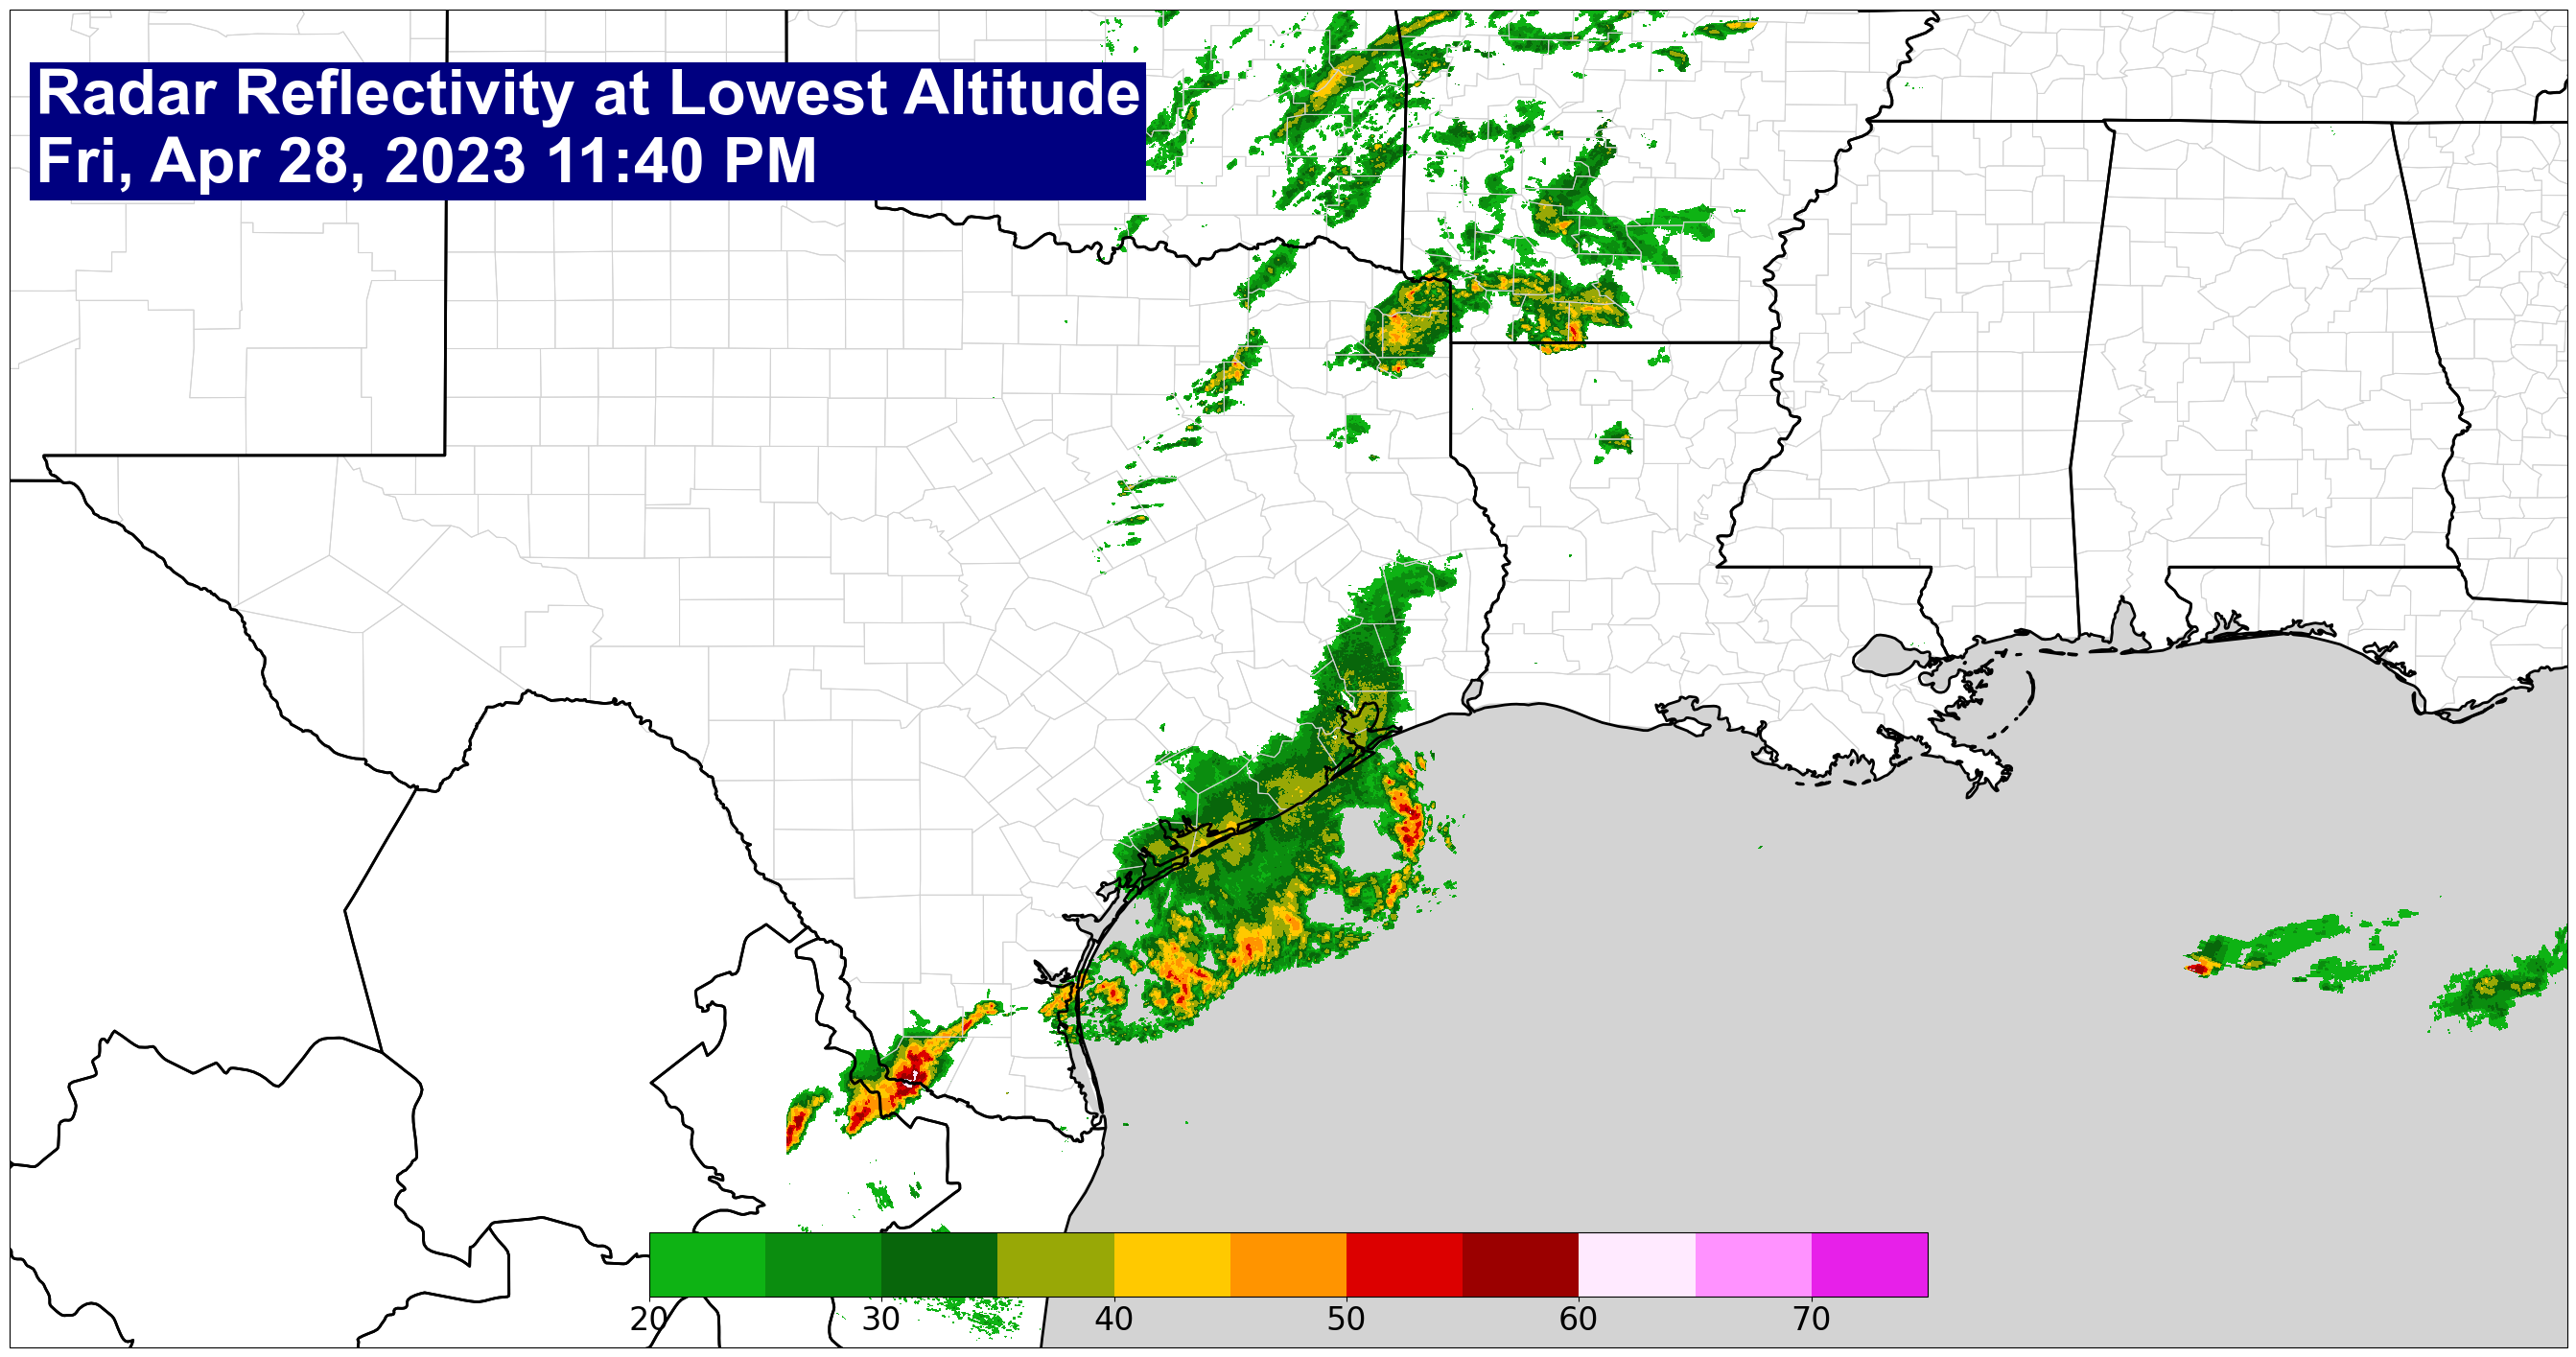

In [8]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
ax.set_extent([-98, -93, 24, 36])

# Define Colormap
norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)

contour = ax.contourf(d.longitude, d.latitude, mrms_values, np.arange(20, 80, 5), 
                     cmap=cmap, norm=Normalize(-30, 80), transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title(f'Radar Reflectivity at Lowest Altitude\n{VALID_TIME}', loc='left', fontname='Arial',
             ha='left', va='top', fontsize=48, color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'mrms'
plt.savefig(f'{graphics_dir}/rain_gauge_corr.png', dpi=72)
plt.show()